Calculate ensemble average for all experiments

In [3]:
import os
import numpy as np
from raug.metrics_2 import Metrics, accuracy
from raug.utils.loader import get_labels_frequency
import pandas as pd

# Especificar o caminho para a pasta "best_results"
folder_path = "best_results"
_csv_path_test = "/home/a52550/Desktop/datasets/ISIC2017/test/ISIC-2017_Test_v2_Part3_GroundTruth.csv"
true_labels = pd.read_csv(_csv_path_test).sort_values(by=['image_id'])['category']

# Inicializar as variáveis para armazenar as previsões dos modelos
ensemble_preds_best = None
ensemble_preds_last = None
num_models = 0
ser_lab_freq = get_labels_frequency(_csv_path_test, "category", "image_id")
_labels_name = ser_lab_freq.index.values #np.reshape(ser_lab_freq.index.values, (ser_lab_freq.index.values.shape[0], 1))

df_best = pd.DataFrame()
df_last = pd.DataFrame()

# Percorrer as pastas de cada experimento
for experiment_folder in os.listdir(folder_path):

    if ".csv" in experiment_folder or ".txt" in experiment_folder:
        continue

    print("Experimento: ", experiment_folder)

    _metric_options_best = {
        'save_all_path': os.path.join(folder_path, experiment_folder, 'ensemble_average/best'),
        'pred_name_scores': 'predictions.csv',
    }
    _metric_options_last = {
        'save_all_path': os.path.join(folder_path, experiment_folder, 'ensemble_average/last'),
        'pred_name_scores': 'predictions.csv',
    }


    experiment_path = os.path.join(folder_path, experiment_folder)
    metrics_best = Metrics (["accuracy", "topk_accuracy", "balanced_accuracy", "conf_matrix" "plot_conf_matrix", "precision_recall_report", "auc_and_roc_curve", "auc"] , _labels_name, _metric_options_best)
    metrics_last = Metrics (["accuracy", "topk_accuracy", "balanced_accuracy", "conf_matrix" "plot_conf_matrix", "precision_recall_report", "auc_and_roc_curve", "auc"] , _labels_name, _metric_options_last)

    ensemble_preds_best = None
    ensemble_preds_last = None

    model_folders = os.listdir(experiment_path)

    # Check if substring "senet154" is present in model_folders
    if any("senet154" in s for s in model_folders):
        continue

    
    # Cria path para o experimento atual
    if 'ensemble_average' in model_folders:
        model_folders.remove('ensemble_average')
    else:
        os.mkdir(os.path.join(folder_path, experiment_folder, 'ensemble_average'))
        os.mkdir(os.path.join(_metric_options_best['save_all_path']))
        os.mkdir(os.path.join(_metric_options_last['save_all_path']))

    if 'ensemble_3_best_average' in model_folders:
        model_folders.remove('ensemble_3_best_average')
    
    if 'ensemble_votation' in model_folders:
        model_folders.remove('ensemble_votation')
    
    if 'DAandPPlatex.txt' in model_folders:
        model_folders.remove('DAandPPlatex.txt')

    model_folders = [x for x in model_folders if ".csv" not in x]

    try:

        # Percorrer as pastas de cada modelo
        for model_folder in model_folders:

            model_path = os.path.join(experiment_path, model_folder)

            # Carregar as previsões do modelo atual
            model_preds_path_best = os.path.join(model_path, "test_pred_best/predictions.csv")
            model_preds_path_last = os.path.join(model_path, "test_pred_last/predictions.csv")

            model_preds_best = pd.read_csv(model_preds_path_best).sort_values(by=['image'])
            model_preds_last = pd.read_csv(model_preds_path_last).sort_values(by=['image'])

            images_id = model_preds_best[['image']]
            model_preds_best = model_preds_best[['0','1','2']]
            model_preds_last = model_preds_last[['0','1','2']]

            # Adicionar as previsões do modelo atual ao ensemble
            if ensemble_preds_best is None:
                ensemble_preds_best = model_preds_best
            else:
                ensemble_preds_best += model_preds_best

            if ensemble_preds_last is None:
                ensemble_preds_last = model_preds_last
            else:
                ensemble_preds_last += model_preds_last

            num_models += 1

        # Calcular a média das previsões dos modelos
        ensemble_preds_best /= num_models
        ensemble_preds_last /= num_models

        metrics_best.update_scores(true_labels, ensemble_preds_best.to_numpy(), images_id.to_numpy())
        metrics_last.update_scores(true_labels, ensemble_preds_last.to_numpy(), images_id.to_numpy())

        metrics_best.compute_metrics()
        metrics_last.compute_metrics()

        metrics_best.save_scores()
        metrics_last.save_scores()

        for auc_metric in metrics_best.metrics_values['auc_and_roc_curve'][0]:
            metrics_best.metrics_values["auc_" + str(auc_metric)] = metrics_best.metrics_values['auc_and_roc_curve'][0][auc_metric]
            metrics_last.metrics_values["auc_" + str(auc_metric)] = metrics_last.metrics_values['auc_and_roc_curve'][0][auc_metric]

        folder_name = {'folder_name': experiment_folder}
        dict_best = {**folder_name, **metrics_best.metrics_values}
        dict_last = {**folder_name, **metrics_last.metrics_values}

        del dict_best['auc_and_roc_curve']
        del dict_best['precision_recall_report']

        del dict_last['auc_and_roc_curve']
        del dict_last['precision_recall_report']

        df_best = df_best.append(pd.DataFrame(dict_best, columns=dict_best.keys(), index=[0]), ignore_index=True)
        df_last = df_last.append(pd.DataFrame(dict_last, columns=dict_last.keys(), index=[0]), ignore_index=True)

    except Exception as e:
        print("Erro no experimento ", experiment_folder)
        print(e)


df_best.to_csv(os.path.join(folder_path, 'ensemble_average_best.csv'), index=False)
df_last.to_csv(os.path.join(folder_path, 'ensemble_average_last.csv'), index=False)

# Avaliar a precisão do modelo de ensemble
# true_classes_path = os.path.join(folder_path, "true_classes.csv")
# true_classes = np.loadtxt(_csv_path_test, delimiter=",", skiprows=1)

# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# accuracy = accuracy_score(true_classes, ensemble_classes)
# precision = precision_score(true_classes, ensemble_classes, average="macro")
# recall = recall_score(true_classes, ensemble_classes, average="macro")
# f1 = f1_score(true_classes, ensemble_classes, average="macro")

# # Imprimir as métricas de avaliação
# print(f"Acurácia: {accuracy:.3f}")
# print(f"Precisão: {precision:.3f}")
# print(f"Recall: {recall:.3f}")
# print(f"F1-score: {f1:.3f}")


Experimento:  dull_razor_shades_of_gray_cropped_images_folder_2
Experimento:  DA0_noPP
Experimento:  noDA_CLAHE_dull_razor_shades_of_gray_cropped_images_folder
Saving the scores in best_results/noDA_CLAHE_dull_razor_shades_of_gray_cropped_images_folder/ensemble_average/best
Saving the scores in best_results/noDA_CLAHE_dull_razor_shades_of_gray_cropped_images_folder/ensemble_average/last
Experimento:  DA0_PP
Saving the scores in best_results/DA0_PP/ensemble_average/best
Saving the scores in best_results/DA0_PP/ensemble_average/last
Experimento:  dull_razor
Experimento:  DA1_noPP
Experimento:  shades_of_gray_cropped_images_folder
Experimento:  DA2_dull_razor_shades_of_gray_cropped_images_folder
Saving the scores in best_results/DA2_dull_razor_shades_of_gray_cropped_images_folder/ensemble_average/best
Saving the scores in best_results/DA2_dull_razor_shades_of_gray_cropped_images_folder/ensemble_average/last
Experimento:  dull_razor_shades_of_gray_cropped_images_folder
Experimento:  DA3_no

/home/a52550/Desktop/masters/cnn/learning_cycle/benchmarks/isic/raug/utils/classification_metrics_2.py:356: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Saving the scores in best_results/noDA_PPcropped_2/ensemble_average/best
Saving the scores in best_results/noDA_PPcropped_2/ensemble_average/last
Experimento:  DA2_noPP
Experimento:  DA0_noPP_2
Saving the scores in best_results/DA0_noPP_2/ensemble_average/best
Saving the scores in best_results/DA0_noPP_2/ensemble_average/last
Experimento:  DA2_CLAHE_shades_of_gray_cropped_images_folder
Saving the scores in best_results/DA2_CLAHE_shades_of_gray_cropped_images_folder/ensemble_average/best
Saving the scores in best_results/DA2_CLAHE_shades_of_gray_cropped_images_folder/ensemble_average/last
Experimento:  CLAHE_2
Experimento:  mean_filter_cropped_images_folder
Experimento:  noDA_CLAHE
Saving the scores in best_results/noDA_CLAHE/ensemble_average/best
Saving the scores in best_results/noDA_CLAHE/ensemble_average/last
Experimento:  train_classifier_only
Saving the scores in best_results/train_classifier_only/ensemble_average/best
Saving the scores in best_results/train_classifier_only/ensemb

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Calculate ensemble average of the best 3 models for all experiments

In [4]:
import os
import numpy as np
from raug.metrics_2 import Metrics, accuracy
from raug.utils.loader import get_labels_frequency
import pandas as pd
from raug.utils import classification_metrics as cmet

# Especificar o caminho para a pasta "best_results"
folder_path = "best_results"
_csv_path_test = "/home/a52550/Desktop/datasets/ISIC2017/test/ISIC-2017_Test_v2_Part3_GroundTruth.csv"
true_labels = pd.read_csv(_csv_path_test).sort_values(by=['image_id'])['category']

# Inicializar as variáveis para armazenar as previsões dos modelos
ensemble_preds_best = None
ensemble_preds_last = None
num_models = 0
ser_lab_freq = get_labels_frequency(_csv_path_test, "category", "image_id")
_labels_name = ser_lab_freq.index.values #np.reshape(ser_lab_freq.index.values, (ser_lab_freq.index.values.shape[0], 1))

df_best = pd.DataFrame()
df_last = pd.DataFrame()

# Percorrer as pastas de cada experimento
for experiment_folder in os.listdir(folder_path):

    try:
        if ".csv" in experiment_folder or ".txt" in experiment_folder:
            continue

        options = {
            'save_all_path': os.path.join(folder_path, experiment_folder, 'ensemble_3_best_average/best'),
            'pred_name_scores': 'predictions.csv',
        }


        experiment_path = os.path.join(folder_path, experiment_folder)

        ensemble_preds_best = None

        model_folders = os.listdir(experiment_path)

        model_folders = [x for x in model_folders if ".csv" not in x]

        # Check if substring "senet154" is present in model_folders
        if any("senet154" in s for s in model_folders):
            print("Experimento ", experiment_folder, " não será avaliado")
            continue

        print("Experimento: ", experiment_folder)

        
        # Cria path para o experimento atual
        if 'ensemble_average' in model_folders:
            model_folders.remove('ensemble_average')
        if 'ensemble_votation' in model_folders:
            model_folders.remove('ensemble_votation')
        if 'ensemble_3_best_average' in model_folders:
            model_folders.remove('ensemble_3_best_average')
        else:
            os.mkdir(os.path.join(folder_path, experiment_folder, 'ensemble_3_best_average'))
            os.mkdir(os.path.join(folder_path, experiment_folder, 'ensemble_3_best_average/best'))

        if 'DAandPPlatex.txt' in model_folders:
            model_folders.remove('DAandPPlatex.txt')

        best_balanced_accuracy = 0
        current_balanced_acuracy = 0
        best_metric_ensemble = None

        # Percorrer as pastas de cada modelo
        for i1 in range(len(model_folders)-1):
            for i2 in range(i1+1, len(model_folders)-1):
                for i3 in range(i2+1, len(model_folders)-1):
                    ensemble_folders = [model_folders[i1], model_folders[i2], model_folders[i3]]

                    metrics_best.options = None

                    for model_folder in ensemble_folders:

                        model_path = os.path.join(experiment_path, model_folder)

                        # Carregar as previsões do modelo atual
                        model_preds_path_best = os.path.join(model_path, "test_pred_best/predictions.csv")

                        model_preds_best = pd.read_csv(model_preds_path_best).sort_values(by=['image'])

                        images_id = model_preds_best[['image']]
                        model_preds_best = model_preds_best[['0','1','2']]

                        # Adicionar as previsões do modelo atual ao ensemble
                        if ensemble_preds_best is None:
                            ensemble_preds_best = model_preds_best
                        else:
                            ensemble_preds_best += model_preds_best

                        num_models += 1

                    # Calcular a média das previsões dos modelos
                    ensemble_preds_best /= num_models
                    
                    # Calcular a balanced accuracy
                    current_balanced_acuracy = cmet.balanced_accuracy(true_labels, ensemble_preds_best.to_numpy())


                    if current_balanced_acuracy > best_balanced_accuracy:
                        best_balanced_accuracy = current_balanced_acuracy

                        best_metric_ensemble = Metrics (["accuracy", "topk_accuracy", "balanced_accuracy", "conf_matrix" "plot_conf_matrix", "precision_recall_report", "auc_and_roc_curve", "auc"], _labels_name, options)
                        best_metric_ensemble.update_scores(true_labels.to_numpy(), ensemble_preds_best.to_numpy(), images_id.to_numpy())

                        best_experiment = experiment_folder

                        ensemble_data = {
                            'folder_name': experiment_folder,
                            'ensemble_3_best': ensemble_folders[0].split('fold')[0] + "_" + ensemble_folders[1].split('fold')[0] + "_" + ensemble_folders[2].split('fold')[0]
                        }
                        

                    ensemble_preds_best = None

        best_metric_ensemble.compute_metrics()
        best_metric_ensemble.save_scores()

        for auc_metric in best_metric_ensemble.metrics_values['auc_and_roc_curve'][0]:
            best_metric_ensemble.metrics_values["auc_" + str(auc_metric)] = best_metric_ensemble.metrics_values['auc_and_roc_curve'][0][auc_metric]
        
        dict_best = {**ensemble_data, **best_metric_ensemble.metrics_values}

        del dict_best['auc_and_roc_curve']
        del dict_best['precision_recall_report']
        # del dict_best['conf_matrix']
        
        df_best = df_best.append(pd.DataFrame(dict_best, columns=dict_best.keys(), index=[0]), ignore_index=True)
    except Exception as e:
        print('Error: ', e)
        continue

df_best.to_csv(os.path.join(folder_path, 'ensemble_3_best_average_best.csv'), index=False)


Experimento  dull_razor_shades_of_gray_cropped_images_folder_2  não será avaliado
Experimento  DA0_noPP  não será avaliado
Experimento:  noDA_CLAHE_dull_razor_shades_of_gray_cropped_images_folder
Saving the scores in best_results/noDA_CLAHE_dull_razor_shades_of_gray_cropped_images_folder/ensemble_3_best_average/best
Experimento:  DA0_PP
Saving the scores in best_results/DA0_PP/ensemble_3_best_average/best
Experimento  dull_razor  não será avaliado
Experimento  DA1_noPP  não será avaliado
Experimento  shades_of_gray_cropped_images_folder  não será avaliado
Experimento:  DA2_dull_razor_shades_of_gray_cropped_images_folder
Saving the scores in best_results/DA2_dull_razor_shades_of_gray_cropped_images_folder/ensemble_3_best_average/best
Experimento  dull_razor_shades_of_gray_cropped_images_folder  não será avaliado
Experimento  DA3_noPP  não será avaliado
Experimento  dull_razor_shades_of_gray  não será avaliado
Experimento:  DA0_noPP_3
Saving the scores in best_results/DA0_noPP_3/ensemble

/home/a52550/Desktop/masters/cnn/learning_cycle/benchmarks/isic/raug/utils/classification_metrics_2.py:356: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Saving the scores in best_results/noDA_CLAHE_dull_razor_shades_of_gray/ensemble_3_best_average/best
Experimento:  dull_razor_shades_of_gray_2
Saving the scores in best_results/dull_razor_shades_of_gray_2/ensemble_3_best_average/best
Experimento  gaussian_filter  não será avaliado
Experimento:  DA2_dull_razor_shades_of_gray_cropped_images_folder_moredata
Saving the scores in best_results/DA2_dull_razor_shades_of_gray_cropped_images_folder_moredata/ensemble_3_best_average/best
Experimento:  shades_of_gray_2
Saving the scores in best_results/shades_of_gray_2/ensemble_3_best_average/best
Experimento:  noDA_dull_razor
Saving the scores in best_results/noDA_dull_razor/ensemble_3_best_average/best
Experimento  noDA_noPP  não será avaliado
Experimento  shades_of_gray  não será avaliado
Experimento  mean_filter  não será avaliado
Experimento  mean_filter_2  não será avaliado
Experimento:  noDA_CLAHE_dull_razor_shades_of_gray_cropped_images_folder_150_epochs
Saving the scores in best_results/noD

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Calculate ensemble by voting for all experiments

In [5]:
import os
import numpy as np
from raug.metrics_2 import Metrics, accuracy
from raug.utils.loader import get_labels_frequency
import pandas as pd

# Especificar o caminho para a pasta "best_results"
folder_path = "best_results"
_csv_path_test = "/home/a52550/Desktop/datasets/ISIC2017/test/ISIC-2017_Test_v2_Part3_GroundTruth.csv"
true_labels = pd.read_csv(_csv_path_test).sort_values(by=['image_id'])['category']

# Inicializar as variáveis para armazenar as previsões dos modelos
ensemble_preds_best = None
ensemble_preds_last = None
num_models = 0
ser_lab_freq = get_labels_frequency(_csv_path_test, "category", "image_id")
_labels_name = ser_lab_freq.index.values #np.reshape(ser_lab_freq.index.values, (ser_lab_freq.index.values.shape[0], 1))

df_best = pd.DataFrame()
df_last = pd.DataFrame()

# Percorrer as pastas de cada experimento
for experiment_folder in os.listdir(folder_path):

    if ".csv" in experiment_folder or ".txt" in experiment_folder:
        continue

    print("Experimento: ", experiment_folder)

    _metric_options_best = {
        'save_all_path': os.path.join(folder_path, experiment_folder, 'ensemble_votation/best'),
        'pred_name_scores': 'predictions.csv',
    }
    _metric_options_last = {
        'save_all_path': os.path.join(folder_path, experiment_folder, 'ensemble_votation/last'),
        'pred_name_scores': 'predictions.csv',
    }


    experiment_path = os.path.join(folder_path, experiment_folder)
    metrics_best = Metrics (["accuracy", "topk_accuracy", "balanced_accuracy", "conf_matrix" "plot_conf_matrix", "precision_recall_report", "auc_and_roc_curve", "auc"] , _labels_name, _metric_options_best)
    metrics_last = Metrics (["accuracy", "topk_accuracy", "balanced_accuracy", "conf_matrix" "plot_conf_matrix", "precision_recall_report", "auc_and_roc_curve", "auc"] , _labels_name, _metric_options_last)

    ensemble_preds_best = None
    ensemble_preds_last = None

    model_folders = os.listdir(experiment_path)
    
    models_folders = [x for x in model_folders if ".csv" not in x]

    # Check if substring "senet154" is present in model_folders
    if any("senet154" in s for s in model_folders):
        continue

    
    # Cria path para o experimento atual
    if 'ensemble_votation' in model_folders:
        model_folders.remove('ensemble_votation')
    else:
        os.mkdir(os.path.join(folder_path, experiment_folder, 'ensemble_votation'))
        os.mkdir(os.path.join(_metric_options_best['save_all_path']))
        os.mkdir(os.path.join(_metric_options_last['save_all_path']))

    if 'ensemble_3_best_average' in model_folders:
        model_folders.remove('ensemble_3_best_average')
    if 'ensemble_average' in model_folders:
        model_folders.remove('ensemble_average')
    if 'DAandPPlatex.txt' in model_folders:
        model_folders.remove('DAandPPlatex.txt')

    model_folders = [x for x in model_folders if ".csv" not in x]

    try:

        # Percorrer as pastas de cada modelo
        for model_folder in model_folders:

            model_path = os.path.join(experiment_path, model_folder)

            # Carregar as previsões do modelo atual
            model_preds_path_best = os.path.join(model_path, "test_pred_best/predictions.csv")
            model_preds_path_last = os.path.join(model_path, "test_pred_last/predictions.csv")

            model_preds_best = pd.read_csv(model_preds_path_best).sort_values(by=['image'])
            model_preds_last = pd.read_csv(model_preds_path_last).sort_values(by=['image'])

            model_preds_best_votation = model_preds_best[['0','1','2']].copy() 
            model_preds_last_votation = model_preds_last[['0','1','2']].copy()

            images_id = model_preds_best[['image']]
            model_preds_best_votation['0'] = (model_preds_best['0'] == model_preds_best[['0','1','2']].max(axis=1)).astype(int)
            model_preds_best_votation['1'] = (model_preds_best['1'] == model_preds_best[['0','1','2']].max(axis=1)).astype(int)
            model_preds_best_votation['2'] = (model_preds_best['2'] == model_preds_best[['0','1','2']].max(axis=1)).astype(int)

            model_preds_last_votation['0'] = (model_preds_last['0'] == model_preds_last[['0','1','2']].max(axis=1)).astype(int)
            model_preds_last_votation['1'] = (model_preds_last['1'] == model_preds_last[['0','1','2']].max(axis=1)).astype(int)
            model_preds_last_votation['2'] = (model_preds_last['2'] == model_preds_last[['0','1','2']].max(axis=1)).astype(int)


            # Adicionar as previsões do modelo atual ao ensemble
            if ensemble_preds_best is None:
                ensemble_preds_best = model_preds_best_votation
            else:
                ensemble_preds_best += model_preds_best_votation

            if ensemble_preds_last is None:
                ensemble_preds_last = model_preds_last_votation
            else:
                ensemble_preds_last += model_preds_last_votation

            num_models += 1

        # Calcular a média das previsões dos modelos
        aux = ensemble_preds_best.copy()
        ensemble_preds_best['0'] = (aux['0'] == aux[['0','1','2']].max(axis=1)).astype(int)
        ensemble_preds_best['1'] = (aux['1'] == aux[['0','1','2']].max(axis=1)).astype(int)
        ensemble_preds_best['2'] = (aux['2'] == aux[['0','1','2']].max(axis=1)).astype(int)

        aux = ensemble_preds_last.copy()
        ensemble_preds_last['0'] = (aux['0'] == aux[['0','1','2']].max(axis=1)).astype(int)
        ensemble_preds_last['1'] = (aux['1'] == aux[['0','1','2']].max(axis=1)).astype(int)
        ensemble_preds_last['2'] = (aux['2'] == aux[['0','1','2']].max(axis=1)).astype(int)

        metrics_best.update_scores(true_labels, ensemble_preds_best.to_numpy(), images_id.to_numpy())
        metrics_last.update_scores(true_labels, ensemble_preds_last.to_numpy(), images_id.to_numpy())

        metrics_best.compute_metrics()
        metrics_last.compute_metrics()

        metrics_best.save_scores()
        metrics_last.save_scores()

        for auc_metric in metrics_best.metrics_values['auc_and_roc_curve'][0]:
            metrics_best.metrics_values["auc_" + str(auc_metric)] = metrics_best.metrics_values['auc_and_roc_curve'][0][auc_metric]
            metrics_last.metrics_values["auc_" + str(auc_metric)] = metrics_last.metrics_values['auc_and_roc_curve'][0][auc_metric]

        folder_name = {'folder_name': experiment_folder}
        dict_best = {**folder_name, **metrics_best.metrics_values}
        dict_last = {**folder_name, **metrics_last.metrics_values}

        del dict_best['auc_and_roc_curve']
        del dict_best['precision_recall_report']

        del dict_last['auc_and_roc_curve']
        del dict_last['precision_recall_report']

        df_best = df_best.append(pd.DataFrame(dict_best, columns=dict_best.keys(), index=[0]), ignore_index=True)
        df_last = df_last.append(pd.DataFrame(dict_last, columns=dict_last.keys(), index=[0]), ignore_index=True)

    except Exception as e:
        print("Erro no experimento ", experiment_folder)
        print(e)


df_best.to_csv(os.path.join(folder_path, 'ensemble_voting_best.csv'), index=False)
df_last.to_csv(os.path.join(folder_path, 'ensemble_voting_last.csv'), index=False)

# Avaliar a precisão do modelo de ensemble
# true_classes_path = os.path.join(folder_path, "true_classes.csv")
# true_classes = np.loadtxt(_csv_path_test, delimiter=",", skiprows=1)

# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# accuracy = accuracy_score(true_classes, ensemble_classes)
# precision = precision_score(true_classes, ensemble_classes, average="macro")
# recall = recall_score(true_classes, ensemble_classes, average="macro")
# f1 = f1_score(true_classes, ensemble_classes, average="macro")

# # Imprimir as métricas de avaliação
# print(f"Acurácia: {accuracy:.3f}")
# print(f"Precisão: {precision:.3f}")
# print(f"Recall: {recall:.3f}")
# print(f"F1-score: {f1:.3f}")


Experimento:  dull_razor_shades_of_gray_cropped_images_folder_2
Experimento:  DA0_noPP
Experimento:  noDA_CLAHE_dull_razor_shades_of_gray_cropped_images_folder
Saving the scores in best_results/noDA_CLAHE_dull_razor_shades_of_gray_cropped_images_folder/ensemble_votation/best
Saving the scores in best_results/noDA_CLAHE_dull_razor_shades_of_gray_cropped_images_folder/ensemble_votation/last
Experimento:  DA0_PP
Saving the scores in best_results/DA0_PP/ensemble_votation/best
Saving the scores in best_results/DA0_PP/ensemble_votation/last
Experimento:  dull_razor
Experimento:  DA1_noPP
Experimento:  shades_of_gray_cropped_images_folder
Experimento:  DA2_dull_razor_shades_of_gray_cropped_images_folder
Saving the scores in best_results/DA2_dull_razor_shades_of_gray_cropped_images_folder/ensemble_votation/best
Saving the scores in best_results/DA2_dull_razor_shades_of_gray_cropped_images_folder/ensemble_votation/last
Experimento:  dull_razor_shades_of_gray_cropped_images_folder
Experimento:  

/home/a52550/Desktop/masters/cnn/learning_cycle/benchmarks/isic/raug/utils/classification_metrics_2.py:356: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Saving the scores in best_results/noDA_PPcropped_2/ensemble_votation/best
Saving the scores in best_results/noDA_PPcropped_2/ensemble_votation/last
Experimento:  DA2_noPP
Experimento:  DA0_noPP_2
Saving the scores in best_results/DA0_noPP_2/ensemble_votation/best
Saving the scores in best_results/DA0_noPP_2/ensemble_votation/last
Experimento:  DA2_CLAHE_shades_of_gray_cropped_images_folder
Saving the scores in best_results/DA2_CLAHE_shades_of_gray_cropped_images_folder/ensemble_votation/best
Saving the scores in best_results/DA2_CLAHE_shades_of_gray_cropped_images_folder/ensemble_votation/last
Experimento:  CLAHE_2
Experimento:  mean_filter_cropped_images_folder
Experimento:  noDA_CLAHE
Saving the scores in best_results/noDA_CLAHE/ensemble_votation/best
Saving the scores in best_results/noDA_CLAHE/ensemble_votation/last
Experimento:  train_classifier_only
Saving the scores in best_results/train_classifier_only/ensemble_votation/best
Saving the scores in best_results/train_classifier_on

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Calculate metrics for each model of each experiments

In [6]:
import os
import numpy as np
from raug.metrics_2 import Metrics, accuracy
from raug.utils.loader import get_labels_frequency
import pandas as pd

# Especificar o caminho para a pasta "best_results"
folder_path = "best_results"
_csv_path_test = "/home/a52550/Desktop/datasets/ISIC2017/test/ISIC-2017_Test_v2_Part3_GroundTruth.csv"
true_labels = pd.read_csv(_csv_path_test).sort_values(by=['image_id'])['category']

# Inicializar as variáveis para armazenar as previsões dos modelos
ensemble_preds_best = None
ensemble_preds_last = None
num_models = 0
ser_lab_freq = get_labels_frequency(_csv_path_test, "category", "image_id")
_labels_name = ser_lab_freq.index.values #np.reshape(ser_lab_freq.index.values, (ser_lab_freq.index.values.shape[0], 1))

# Percorrer as pastas de cada experimento
for experiment_folder in os.listdir(folder_path):

    df_best = pd.DataFrame()
    df_last = pd.DataFrame()


    if ".csv" in experiment_folder or ".txt" in experiment_folder:
        continue

    print("Experimento: ", experiment_folder)


    experiment_path = os.path.join(folder_path, experiment_folder)

    ensemble_preds_best = None
    ensemble_preds_last = None

    model_folders = os.listdir(experiment_path)

    # Check if substring "senet154" is present in model_folders
    if any("senet154" in s for s in model_folders):
        continue

    
    # Cria path para o experimento atual
    if 'ensemble_average' in model_folders:
        model_folders.remove('ensemble_average')
    else:
        os.mkdir(os.path.join(folder_path, experiment_folder, 'ensemble_average'))
        os.mkdir(os.path.join(_metric_options_best['save_all_path']))
        os.mkdir(os.path.join(_metric_options_last['save_all_path']))

    if 'ensemble_3_best_average' in model_folders:
        model_folders.remove('ensemble_3_best_average')
    
    if 'ensemble_votation' in model_folders:
        model_folders.remove('ensemble_votation')

    if 'DAandPPlatex.txt' in model_folders:
        model_folders.remove('DAandPPlatex.txt')

    model_folders = [x for x in model_folders if ".csv" not in x]

    try:

        # Percorrer as pastas de cada modelo
        for model_folder in model_folders:

            model_path = os.path.join(experiment_path, model_folder)
            _metric_options_best = {
                'save_all_path': os.path.join(model_path, 'new_test_pred_best'),
                'pred_name_scores': 'predictions.csv',
            }
            _metric_options_last = {
                'save_all_path': os.path.join(model_path, 'new_test_pred_last'),
                'pred_name_scores': 'predictions.csv',
            }

            if 'new_test_pred_best' not in os.listdir(model_path):
                os.mkdir(os.path.join(model_path, 'new_test_pred_best'))
            if 'new_test_pred_last' not in os.listdir(model_path):
                os.mkdir(os.path.join(model_path, 'new_test_pred_last'))

            # Carregar as previsões do modelo atual
            model_preds_path_best = os.path.join(model_path, "test_pred_best/predictions.csv")
            model_preds_path_last = os.path.join(model_path, "test_pred_last/predictions.csv")

            model_preds_best = pd.read_csv(model_preds_path_best).sort_values(by=['image'])
            model_preds_last = pd.read_csv(model_preds_path_last).sort_values(by=['image'])

            metrics_best = Metrics (["accuracy", "topk_accuracy", "balanced_accuracy", "conf_matrix" "plot_conf_matrix", "precision_recall_report", "auc_and_roc_curve", "auc"] , _labels_name, _metric_options_best)
            metrics_last = Metrics (["accuracy", "topk_accuracy", "balanced_accuracy", "conf_matrix" "plot_conf_matrix", "precision_recall_report", "auc_and_roc_curve", "auc"] , _labels_name, _metric_options_last)

            metrics_best.update_scores(true_labels, model_preds_best[['0','1','2']].to_numpy(), model_preds_best[['image']].to_numpy())
            metrics_last.update_scores(true_labels, model_preds_best[['0','1','2']].to_numpy(), model_preds_best[['image']].to_numpy())

            metrics_best.compute_metrics()
            metrics_last.compute_metrics()

            metrics_best.save_scores()
            metrics_last.save_scores()

            for auc_metric in metrics_best.metrics_values['auc_and_roc_curve'][0]:
                metrics_best.metrics_values["auc_" + str(auc_metric)] = metrics_best.metrics_values['auc_and_roc_curve'][0][auc_metric]
                metrics_last.metrics_values["auc_" + str(auc_metric)] = metrics_last.metrics_values['auc_and_roc_curve'][0][auc_metric]
            
            # del metrics_best.metrics_values['conf_matrix']
            del metrics_best.metrics_values['auc_and_roc_curve']
            del metrics_best.metrics_values['precision_recall_report']

            # del metrics_last.metrics_values['conf_matrix']
            del metrics_last.metrics_values['auc_and_roc_curve']
            del metrics_last.metrics_values['precision_recall_report']

            folder_name = {'folder_name': model_folder, 'model_name': model_folder.split('_fold')[0]}
            dict_best = {**folder_name, **metrics_best.metrics_values}
            dict_last = {**folder_name, **metrics_last.metrics_values}


            df_best = df_best.append(pd.DataFrame(dict_best, columns=dict_best.keys(), index=[0]), ignore_index=True)
            df_last = df_last.append(pd.DataFrame(dict_last, columns=dict_last.keys(), index=[0]), ignore_index=True)

    except Exception as e:
        print("Erro no experimento ", experiment_folder)
        print(e)


    df_best.to_csv(os.path.join(experiment_path, 'results_best.csv'), index=False)
    df_last.to_csv(os.path.join(experiment_path, 'results_last.csv'), index=False)

# Avaliar a precisão do modelo de ensemble
# true_classes_path = os.path.join(folder_path, "true_classes.csv")
# true_classes = np.loadtxt(_csv_path_test, delimiter=",", skiprows=1)

# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# accuracy = accuracy_score(true_classes, ensemble_classes)
# precision = precision_score(true_classes, ensemble_classes, average="macro")
# recall = recall_score(true_classes, ensemble_classes, average="macro")
# f1 = f1_score(true_classes, ensemble_classes, average="macro")

# # Imprimir as métricas de avaliação
# print(f"Acurácia: {accuracy:.3f}")
# print(f"Precisão: {precision:.3f}")
# print(f"Recall: {recall:.3f}")
# print(f"F1-score: {f1:.3f}")


Experimento:  dull_razor_shades_of_gray_cropped_images_folder_2
Experimento:  DA0_noPP
Experimento:  noDA_CLAHE_dull_razor_shades_of_gray_cropped_images_folder
Saving the scores in best_results/noDA_CLAHE_dull_razor_shades_of_gray_cropped_images_folder/efficientnet_b3_fold-1_lrinit-0.001_batchsize-32_optimizer-Adam_maxepochs-50_DA-None_PPen-CLAHE_PPha-dull_razor_PPco-shades_of_gray_PPde-None_PPno-True_PPcr-cropped_images_folder_PPre-True_drop-0.0_trainjustclassifier-False_16824953797804499/new_test_pred_best
Saving the scores in best_results/noDA_CLAHE_dull_razor_shades_of_gray_cropped_images_folder/efficientnet_b3_fold-1_lrinit-0.001_batchsize-32_optimizer-Adam_maxepochs-50_DA-None_PPen-CLAHE_PPha-dull_razor_PPco-shades_of_gray_PPde-None_PPno-True_PPcr-cropped_images_folder_PPre-True_drop-0.0_trainjustclassifier-False_16824953797804499/new_test_pred_last
Saving the scores in best_results/noDA_CLAHE_dull_razor_shades_of_gray_cropped_images_folder/tf_efficientnet_b6_fold-1_lrinit-0.0001

/home/a52550/Desktop/masters/cnn/learning_cycle/benchmarks/isic/raug/utils/classification_metrics_2.py:356: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Saving the scores in best_results/noDA_CLAHE_dull_razor_shades_of_gray_cropped_images_folder/resnest101e_fold-1_lrinit-0.0001_batchsize-8_optimizer-AdamW_maxepochs-50_DA-None_PPen-CLAHE_PPha-dull_razor_PPco-shades_of_gray_PPde-None_PPno-True_PPcr-cropped_images_folder_PPre-True_drop-0.0_trainjustclassifier-False_16824987557730577/new_test_pred_best
Saving the scores in best_results/noDA_CLAHE_dull_razor_shades_of_gray_cropped_images_folder/resnest101e_fold-1_lrinit-0.0001_batchsize-8_optimizer-AdamW_maxepochs-50_DA-None_PPen-CLAHE_PPha-dull_razor_PPco-shades_of_gray_PPde-None_PPno-True_PPcr-cropped_images_folder_PPre-True_drop-0.0_trainjustclassifier-False_16824987557730577/new_test_pred_last
Saving the scores in best_results/noDA_CLAHE_dull_razor_shades_of_gray_cropped_images_folder/tf_efficientnet_b5_fold-1_lrinit-0.0001_batchsize-8_optimizer-AdamW_maxepochs-50_DA-None_PPen-CLAHE_PPha-dull_razor_PPco-shades_of_gray_PPde-None_PPno-True_PPcr-cropped_images_folder_PPre-True_drop-0.0_tra

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Calculate the metrics for the best ensemble

In [2]:
import os
import numpy as np
from raug.metrics_2 import Metrics, accuracy
from raug.utils.loader import get_labels_frequency
import pandas as pd

# Especificar o caminho para a pasta "best_results"
folder_path = "best_results"
_csv_path_test = "/home/a52550/Desktop/datasets/ISIC2017/test/ISIC-2017_Test_v2_Part3_GroundTruth.csv"
true_labels = pd.read_csv(_csv_path_test).sort_values(by=['image_id'])['category']

# Inicializar as variáveis para armazenar as previsões dos modelos
ensemble_preds_best = None
ensemble_preds_last = None
num_models = 0
ser_lab_freq = get_labels_frequency(_csv_path_test, "category", "image_id")
_labels_name = ser_lab_freq.index.values #np.reshape(ser_lab_freq.index.values, (ser_lab_freq.index.values.shape[0], 1))

# Percorrer as pastas de cada experimento
experiment_folder = 'DA2_dull_razor_shades_of_gray_cropped_images_folder'

try:

    print("Experimento: ", experiment_folder)

    experiment_path = os.path.join(folder_path, experiment_folder)

    ensemble_preds_best = None

    # Carregar as previsões do modelo atual
    model_preds_path_best = '/home/a52550/Desktop/masters/cnn/learning_cycle/benchmarks/isic/best_results/DA2_dull_razor_shades_of_gray_cropped_images_folder/ensemble_3_best_average/best/predictions.csv'

    model_preds_best = pd.read_csv(model_preds_path_best).sort_values(by=['image'])

    metrics_best = Metrics (["accuracy", "topk_accuracy", "balanced_accuracy", "conf_matrix" "plot_conf_matrix", "precision_recall_report", "auc_and_roc_curve", "auc"] , _labels_name)

    metrics_best.update_scores(true_labels, model_preds_best[['0','1','2']].to_numpy(), model_preds_best[['image']].to_numpy())

    metrics_best.compute_metrics()

    print(metrics_best.metrics_values)


except Exception as e:
    print("Erro no experimento ", experiment_folder)
    print(e)

# Avaliar a precisão do modelo de ensemble
# true_classes_path = os.path.join(folder_path, "true_classes.csv")
# true_classes = np.loadtxt(_csv_path_test, delimiter=",", skiprows=1)

# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# accuracy = accuracy_score(true_classes, ensemble_classes)
# precision = precision_score(true_classes, ensemble_classes, average="macro")
# recall = recall_score(true_classes, ensemble_classes, average="macro")
# f1 = f1_score(true_classes, ensemble_classes, average="macro")

# # Imprimir as métricas de avaliação
# print(f"Acurácia: {accuracy:.3f}")
# print(f"Precisão: {precision:.3f}")
# print(f"Recall: {recall:.3f}")
# print(f"F1-score: {f1:.3f}")


Experimento:  DA2_dull_razor_shades_of_gray_cropped_images_folder
{'accuracy': 0.8283333333333334, 'topk_accuracy': 0.955, 'balanced_accuracy': 0.8131989299928231, 'precision_recall_report': '              precision    recall  f1-score   support\n\n           0       0.92      0.85      0.88       393\n           1       0.67      0.71      0.69       117\n           2       0.71      0.88      0.79        90\n\n    accuracy                           0.83       600\n   macro avg       0.77      0.81      0.79       600\nweighted avg       0.84      0.83      0.83       600\n', 'auc_and_roc_curve': ({0: 0.9228774077761798, 1: 0.8957194174585479, 2: 0.9642701525054467, '1_2': 0.9299947849819973, 'macro': 0.9289600391885587, 'micro': 0.9430819444444445}, {0: array([0.        , 0.        , 0.        , 0.00483092, 0.00483092,
       0.00966184, 0.00966184, 0.01449275, 0.01449275, 0.01932367,
       0.01932367, 0.02898551, 0.02898551, 0.03381643, 0.03381643,
       0.04347826, 0.04347826, 0.

In [ ]:
import os
import numpy as np
from raug.metrics_2 import Metrics, accuracy
from raug.utils.loader import get_labels_frequency
import pandas as pd

# Especificar o caminho para a pasta "best_results"
folder_path = "best_results"
_csv_path_test = "/home/a52550/Desktop/datasets/ISIC2017/test/ISIC-2017_Test_v2_Part3_GroundTruth.csv"
true_labels = pd.read_csv(_csv_path_test).sort_values(by=['image_id'])['category']

# Inicializar as variáveis para armazenar as previsões dos modelos
ensemble_preds_best = None
ensemble_preds_last = None
num_models = 0
ser_lab_freq = get_labels_frequency(_csv_path_test, "category", "image_id")
_labels_name = ser_lab_freq.index.values #np.reshape(ser_lab_freq.index.values, (ser_lab_freq.index.values.shape[0], 1))

df_best = pd.DataFrame()
df_last = pd.DataFrame()

experiment_folder = 'DA2_dull_razor_shades_of_gray_cropped_images_folder'

print("Experimento: ", experiment_folder)


experiment_path = os.path.join(folder_path, experiment_folder)

ensemble_preds_best = None
ensemble_preds_last = None

model_folders = os.listdir(experiment_path)


# Cria path para o experimento atual
if 'ensemble_average' in model_folders:
    model_folders.remove('ensemble_average')

if 'ensemble_3_best_average' in model_folders:
    model_folders.remove('ensemble_3_best_average')

if 'ensemble_votation' in model_folders:
    model_folders.remove('ensemble_votation')

if 'DAandPPlatex.txt' in model_folders:
    model_folders.remove('DAandPPlatex.txt')

model_folders = [x for x in model_folders if ".csv" not in x]

try:

    all_preds_best = None
    all_preds_last = None

    # Percorrer as pastas de cada modelo
    for model_folder in model_folders:

        model_path = os.path.join(experiment_path, model_folder)

        # Carregar as previsões do modelo atual
        model_preds_path_best = os.path.join(model_path, "test_pred_best/predictions.csv")
        model_preds_path_last = os.path.join(model_path, "test_pred_last/predictions.csv")

        # Merge das previsões do modelo atual com as previsões de todos os modelos
        if all_preds_best is None:
            model_preds_best = pd.read_csv(model_preds_path_best).sort_values(by=['image'])[['image', 'REAL', 'PRED']]
            model_preds_last = pd.read_csv(model_preds_path_last).sort_values(by=['image'])[['image', 'REAL', 'PRED']]

            #Substituir nome da coluna PRED por nome do modelo
            model_preds_best.rename(columns={'PRED': model_folder.split('_fold')[0]}, inplace=True)
            model_preds_last.rename(columns={'PRED': model_folder.split('_fold')[0]}, inplace=True)

            all_preds_best = model_preds_best
            all_preds_last = model_preds_last
        else:
            model_preds_best = pd.read_csv(model_preds_path_best).sort_values(by=['image'])[['image', 'PRED']]
            model_preds_last = pd.read_csv(model_preds_path_last).sort_values(by=['image'])[['image', 'PRED']]

            #Substituir nome da coluna PRED por nome do modelo
            model_preds_best.rename(columns={'PRED': model_folder.split('_fold')[0]}, inplace=True)
            model_preds_last.rename(columns={'PRED': model_folder.split('_fold')[0]}, inplace=True)

            all_preds_best = pd.merge(all_preds_best, model_preds_best, on='image')
            all_preds_last = pd.merge(all_preds_last, model_preds_last, on='image')


except Exception as e:
    print("Erro no experimento ", experiment_folder)
    print(e)


In [ ]:

# Define a function to count correct guesses for each row
def count_correct_guesses(row):
    correct_guesses = 0
    for model in all_preds_best.columns[2:-1]:
        if (row[model] == row['REAL']):
            correct_guesses += 1
    return correct_guesses

# Create a new column to store the count of correct guesses
all_preds_best['correct_guesses'] = all_preds_best.apply(count_correct_guesses, axis=1)

all_preds_best.to_csv('count_correct_guesses.csv', index=False)

# Def

Create results_all_models_all_experiments_new

In [7]:
import os
import numpy as np
from raug.metrics_2 import Metrics, accuracy
from raug.utils.loader import get_labels_frequency
import pandas as pd
from raug.utils import classification_metrics as cmet

# Especificar o caminho para a pasta "best_results"
folder_path = "best_results"

df = None

# Percorrer as pastas de cada experimento
for experiment_folder in os.listdir(folder_path):

    try:
        if ".csv" in experiment_folder or ".txt" in experiment_folder:
            continue

        experiment_path = os.path.join(folder_path, experiment_folder)

        ensemble_preds_best = None

        # Check if substring "senet154" is present in model_folders
        if any("senet154" in s for s in os.listdir(experiment_path)):
            print("Experimento ", experiment_folder, " não será avaliado")
            continue

        print("Experimento: ", experiment_folder)


        # Carregar as previsões do modelo atual
        results_path_csv = os.path.join(experiment_path, "results_best.csv")

        results = pd.read_csv(results_path_csv)[['model_name','balanced_accuracy']].sort_values(by=['model_name'])
        
        #rename columns to experiment name
        results.rename(columns={'balanced_accuracy': experiment_folder}, inplace=True)

        if df is None:
            df = results
        else:
            #merge by model_name
            df = pd.merge(df, results, on='model_name', how='left')


    except Exception as e:
        print('Error: ', e)
        continue

df.to_csv(os.path.join(folder_path, 'results_all_models_all_experiments_new.csv'), index=False)


Experimento  dull_razor_shades_of_gray_cropped_images_folder_2  não será avaliado
Experimento  DA0_noPP  não será avaliado
Experimento:  noDA_CLAHE_dull_razor_shades_of_gray_cropped_images_folder
Experimento:  DA0_PP
Experimento  dull_razor  não será avaliado
Experimento  DA1_noPP  não será avaliado
Experimento  shades_of_gray_cropped_images_folder  não será avaliado
Experimento:  DA2_dull_razor_shades_of_gray_cropped_images_folder
Experimento  dull_razor_shades_of_gray_cropped_images_folder  não será avaliado
Experimento  DA3_noPP  não será avaliado
Experimento  dull_razor_shades_of_gray  não será avaliado
Experimento:  DA0_noPP_3
Experimento  dull_razor_2  não será avaliado
Experimento:  DA2_noPP_2
Experimento:  DA2_CLAHE_dull_razor_shades_of_gray_cropped_images_folder
Experimento:  DA2_cropped_images_folder_150_epochs_lr_init_0001
Experimento  non_local_means_cropped_images_folder  não será avaliado
Experimento:  noDA_dull_razor_shades_of_gray_cropped_images_folder
Experimento  DA1_

In [ ]:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# gauth = GoogleAuth()   
# gauth.LocalWebserverAuth()
# drive = GoogleDrive(gauth)  

# densenet121_fold-1_lrinit-0.0001_batchsize-32_optimizer-Adam_maxepochs-150_DA-2_PPen-None_PPha-None_PPco-shades_of_gray_PPde-None_PPno-True_PPcr-cropped_images_folder_PPre-True_drop-0.0_trainjustclassifier-False_1681078943104982

## Plot graphs

Experimento:  shades_of_gray_2


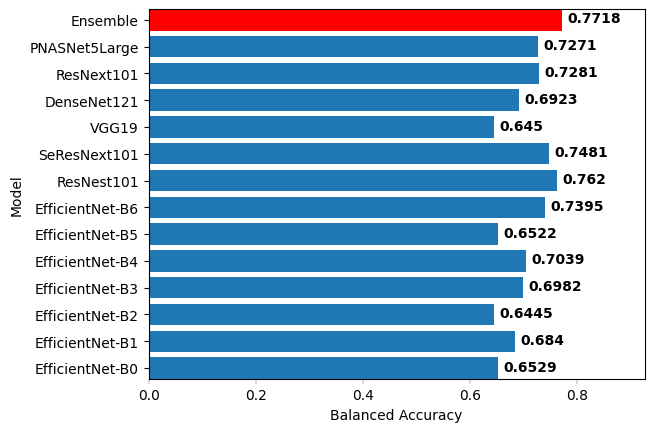

In [9]:
import os
import pandas as pd

# Especificar o caminho para a pasta "best_results"
folder_path = "best_results"

df = None

experiment_folder = 'shades_of_gray_2'
# experiment_folder = 'DA2_cropped_images_folder_150_epochs_lr_init_0001'


experiment_path = os.path.join(folder_path, experiment_folder)

ensemble_preds_best = None

print("Experimento: ", experiment_folder)


# Carregar as previsões do modelo atual
results_path_csv = os.path.join(experiment_path, "results_best.csv")

results = pd.read_csv(results_path_csv)[['model_name','balanced_accuracy']].sort_values(by=['model_name'])

# get balanced accuracy for model_name
all_results = results.loc[results.model_name.isin(['efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'tf_efficientnet_b5', 'tf_efficientnet_b6', 'resnest101e', 'seresnext101_32x8d', 'densenet121', 'resnext101_32x8d', 'vgg19', 'pnasnet5large' ]),:].set_index('model_name').to_dict()
# all_results = results.set_index('model_name').to_dict()


ensemble_results_path_csv = os.path.join(folder_path, "ensemble_voting_best.csv")
ensemble_result = pd.read_csv(ensemble_results_path_csv)[['folder_name','balanced_accuracy']]
ensemble_result = ensemble_result.loc[ensemble_result.folder_name.isin([experiment_folder]),:].set_index('folder_name').to_dict()

all_results = {**all_results['balanced_accuracy'], **ensemble_result['balanced_accuracy']}

#tf_efficientnet_b5, pnasnet5large, tf_efficientnet_b6, efficientnet_b4, efficientnet_b3, efficientnet_b1, resnest101e, efficientnet_b2, efficientnet_b0, seresnext101_32x8d, densenet121, vgg19, resnext101_32x8d


all_results['EfficientNet-B0'] = all_results.pop('efficientnet_b0')
all_results['EfficientNet-B1'] = all_results.pop('efficientnet_b1')
all_results['EfficientNet-B2'] = all_results.pop('efficientnet_b2')
all_results['EfficientNet-B3'] = all_results.pop('efficientnet_b3')
all_results['EfficientNet-B4'] = all_results.pop('efficientnet_b4')
all_results['EfficientNet-B5'] = all_results.pop('tf_efficientnet_b5')
all_results['EfficientNet-B6'] = all_results.pop('tf_efficientnet_b6')
all_results['ResNest101'] = all_results.pop('resnest101e')
all_results['SeResNext101'] = all_results.pop('seresnext101_32x8d')
all_results['VGG19'] = all_results.pop('vgg19')
all_results['DenseNet121'] = all_results.pop('densenet121')
all_results['ResNext101'] = all_results.pop('resnext101_32x8d')
all_results['PNASNet5Large'] = all_results.pop('pnasnet5large')
all_results['Ensemble'] = all_results.pop(experiment_folder)


# create horizonal bar plot
import matplotlib.pyplot as plt
import numpy as np

# Data
r = all_results
bars = tuple(r.keys())
y_pos = np.arange(len(bars))
height = list(r.values())

# Create bars
plt.barh(y_pos, height)

# Create names on the x-axis
plt.yticks(y_pos, bars)

# Add title and axis names
plt.xlabel('Balanced Accuracy')
plt.ylabel('Model')

# Color the highest bar
plt.gca().patches[height.index(max(height))].set_facecolor('red')

# Add the labels to each bar
for i, v in enumerate(height):
    # Round v with 4 decimals
    v = round(v,4)
    plt.text(v+.01, i - 0.1, str(v), fontweight='bold')

# Make the right margin wider so that the labels are inside the figure
plt.margins(0.2, 0)

# Make bars thinner
plt.gca().xaxis.set_tick_params(width=0.2)


# Show graphic
plt.show()

# df.to_csv(os.path.join(folder_path, 'results_all_models_all_experiments_new.csv'), index=False)


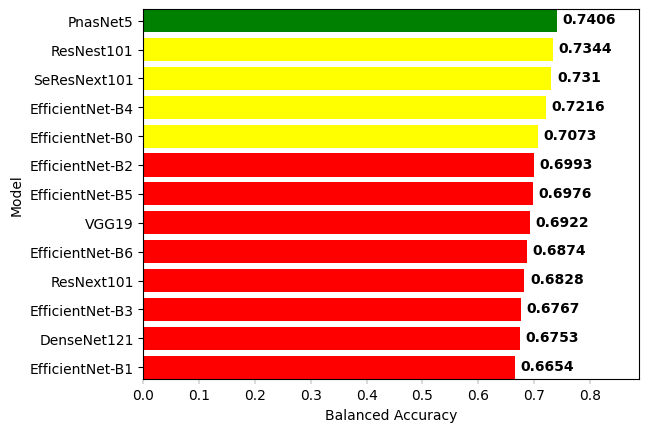

In [2]:
# create horizonal bar plot
import matplotlib.pyplot as plt
import numpy as np

#Balanced accuracy for each model - no pre-processing and no data augmentation
data = {
    "EfficientNet-B0": 0.7073,
    "EfficientNet-B1": 0.6654,
    "EfficientNet-B2": 0.6993,
    "EfficientNet-B3": 0.6767,
    "EfficientNet-B4": 0.7216,
    "EfficientNet-B5": 0.6976,
    "EfficientNet-B6": 0.6874,
    "ResNest101": 0.7344,
    "SeResNext101": 0.7310,
    "VGG19": 0.6922,
    "DenseNet121": 0.6753,
    "ResNext101": 0.6828,
    "PnasNet5": 0.7406
}

# Sort the data
data = dict(sorted(data.items(), key=lambda item: item[1]))

# Data
r = data
bars = tuple(r.keys())
y_pos = np.arange(len(bars))
height = list(r.values())

# Create bars
plt.barh(y_pos, height)

# Create names on the x-axis
plt.yticks(y_pos, bars)

# Add title and axis names
plt.xlabel('Balanced Accuracy')
plt.ylabel('Model')

for h in height:
    if h > 0.7:
        plt.gca().patches[height.index(h)].set_facecolor('yellow')
    else:
        plt.gca().patches[height.index(h)].set_facecolor('red')
# Color the highest bar
plt.gca().patches[height.index(max(height))].set_facecolor('green')
# Color the highest bar

# Add the labels to each bar
for i, v in enumerate(height):
    # Round v with 4 decimals
    v = round(v,4)
    plt.text(v+.01, i - 0.1, str(v), fontweight='bold')

# Make the right margin wider so that the labels are inside the figure
plt.margins(0.2, 0)

# Make bars thinner
plt.gca().xaxis.set_tick_params(width=0.2)


# Show graphic
plt.show()


In [1]:

#Balanced accuracy for each model - no pre-processing and data augmentation
data = {
    "EfficientNet-B0": 0.7170,
    "EfficientNet-B1": 0.7064,
    "EfficientNet-B2": 0.7006,
    "EfficientNet-B3": 0.7356,
    "EfficientNet-B4": 0.7441,
    "EfficientNet-B5": 0.7653,
    "EfficientNet-B6": 0.7651,
    "ResNest101": 0.7459,
    "SeResNext101": 0.7432,
    "DenseNet121": 0.7182,
    "ResNext101": 0.7016,
    "VGG19": 0.6786,
    "PnasNet5": 0.7412
}

# Sort the data
data = dict(sorted(data.items(), key=lambda item: item[1]))

# Data
r = data
bars = tuple(r.keys())
y_pos = np.arange(len(bars))
height = list(r.values())

# Create bars
plt.barh(y_pos, height)

# Create names on the x-axis
plt.yticks(y_pos, bars)

# Add title and axis names
plt.xlabel('Balanced Accuracy')
plt.ylabel('Model')

# Color the highest bar
plt.gca().patches[height.index(max(height))].set_facecolor('red')

# Add the labels to each bar
for i, v in enumerate(height):
    # Round v with 4 decimals
    v = round(v,4)
    plt.text(v+.01, i - 0.1, str(v), fontweight='bold')

# Make the right margin wider so that the labels are inside the figure
plt.margins(0.2, 0)

# Make bars thinner
plt.gca().xaxis.set_tick_params(width=0.2)


# Show graphic
plt.show()


NameError: name 'np' is not defined

In [ ]:
data = {
    "Average": {"With DA and PP*": 0.8064,"With DA": 0.7811, "With PP*": 0.7758, "Without DA and PP": 0.7547},
    "Average of 3": {"With DA and PP*": 0.8132,"With DA": 0.7939, "With PP*":0.7879, "Without DA and PP": 0.7671},
    "Voting": {"With DA and PP*": 0.7987,"With DA": 0.7882, "With PP*": 0.7718, "Without DA and PP": 0.7371},
}

# Preparação dos dados para plotagem
labels = list(data.keys())
da_pp_values = [data[label]['With DA and PP*'] for label in labels]
da_values = [data[label]['With DA'] for label in labels]
pp_values = [data[label]['With PP*'] for label in labels]
no_pp_values = [data[label]['Without DA and PP'] for label in labels]


y = np.arange(len(labels))  # Posições dos grupos de barras
width = 0.2  # Largura das barras

# Plotagem dos resultados
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.barh(y + 3*width/2, da_pp_values, width, label='With DA and PP*')
rects2 = ax.barh(y + width/2, da_values, width, label='With DA')
rects3 = ax.barh(y - width/2, pp_values, width, label='With PP*')
rects4 = ax.barh(y - 3*width/2, no_pp_values, width, label='Without DA and PP')

# Adicionar rótulos, títulos e legendas
ax.set_ylabel('Ensemble')
ax.set_xlabel('Balanced Accuracy')
ax.set_title('Ensemble results for each experiment')
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.legend()

# Adicionar rótulos em cada barra
def autolabel(rects):
    for rect in rects:
        width = rect.get_width()
        ax.annotate('{}'.format(round(width,4)),
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(3, 0),  # Deslocamento horizontal e vertical
                    textcoords="offset points",  # Interpretar 'xy' como deslocamento em pontos
                    ha='left', va='center', fontweight='bold')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

# Make the right margin wider so that the labels are inside the figure
plt.margins(0.40, 0)

annotation_text = "*Note: Best combination of image pre-processing techniques for each ensemble."
plt.annotate(annotation_text, xy=(0.55, 0), xytext=(0, -40),
             xycoords='axes fraction', textcoords='offset points',
             ha='right', va='top')

# Make bars thinner
plt.gca().xaxis.set_tick_params(width=0.2)

plt.tight_layout()
plt.show()

In [ ]:
# data = {
#     "EfficientNet-B0": {"Without PP": 0.7073,"A": 0.6871,"B": 0.6529,"C": 0.6960,"D": 0.6623,"BC": 0.6968,"ABC": 0.6304,"BCD": 0.6645,"ABCD": 0.6096},
#     "EfficientNet-B1": {"Without PP": 0.6654,"A": 0.6716,"B": 0.6840,"C": 0.6601,"D": 0.6880,"BC": 0.7016,"ABC": 0.6440,"BCD": 0.6255,"ABCD": 0.6944},
#     "EfficientNet-B2": {"Without PP": 0.6993,"A": 0.6957,"B": 0.6445,"C": 0.7091,"D": 0.6572,"BC": 0.6833,"ABC": 0.6600,"BCD": 0.6928,"ABCD": 0.6262},
#     "EfficientNet-B3": {"Without PP": 0.6767,"A": 0.7120,"B": 0.6982,"C": 0.7248,"D": 0.6830,"BC": 0.7010,"ABC": 0.6612,"BCD": 0.7278,"ABCD": 0.7260},
#     "EfficientNet-B4": {"Without PP": 0.7216,"A": 0.6944,"B": 0.7039,"C": 0.7093,"D": 0.6734,"BC": 0.7317,"ABC": 0.6493,"BCD": 0.7284,"ABCD": 0.6470},
#     "EfficientNet-B5": {"Without PP": 0.6976,"A": 0.7113,"B": 0.6522,"C": 0.7099,"D": 0.7250,"BC": 0.6816,"ABC": 0.6814,"BCD": 0.6846,"ABCD": 0.6958},
#     "EfficientNet-B6": {"Without PP": 0.6874,"A": 0.6943,"B": 0.7395,"C": 0.7213,"D": 0.6735,"BC": 0.7139,"ABC": 0.7057,"BCD": 0.6953,"ABCD": 0.6856},
#     "ResNest101": {"Without PP": 0.7344,"A": 0.7104,"B": 0.7620,"C": 0.7447,"D": 0.6993,"BC": 0.7083,"ABC": 0.6706,"BCD": 0.7070,"ABCD": 0.7306},
#     "SeResNext101": {"Without PP": 0.7310,"A": 0.7032,"B": 0.7481,"C": 0.6863,"D": 0.7117,"BC": 0.7165,"ABC": 0.6650,"BCD": 0.6939,"ABCD": 0.6634},
#     "VGG19": {"Without PP": 0.6922,"A": 0.6011,"B": 0.6450,"C": 0.6606,"D": 0.6121,"BC": 0.6506,"ABC": 0.6546,"BCD": 0.6142,"ABCD": 0.6532},
#     "DenseNet121": {"Without PP": 0.6753,"A": 0.6716,"B": 0.6923,"C": 0.7176,"D": 0.6974,"BC": 0.6282,"ABC": 0.6092,"BCD": 0.6534,"ABCD": 0.6330},
#     "ResNext101": {"Without PP": 0.6828,"A": 0.6731,"B": 0.7281,"C": 0.6957,"D": 0.7194,"BC": 0.7253,"ABC": 0.6535,"BCD": 0.6967,"ABCD": 0.6950},
#     "PnasNet5": {"Without PP": 0.7406,"A": 0.6718,"B": 0.7271,"C": 0.7398,"D": 0.7522,"BC": 0.7123,"ABC": 0.6963,"BCD": 0.6871,"ABCD": 0.6783}
# }

data = {
    "PnasNet5": {"No DA": 0.7406,"DA": 0.7412},
    "VGG19": {"No DA": 0.6922,"DA": 0.6786},
    "ResNext101": {"No DA": 0.6828,"DA": 0.7016},
    "DenseNet121": {"No DA": 0.6753,"DA": 0.7182},
    "SeResNext101": {"No DA": 0.7310,"DA": 0.7432},
    "ResNest101": {"No DA": 0.7344,"DA": 0.7459},
    "EfficientNet-B6": {"No DA": 0.6874,"DA": 0.7651},
    "EfficientNet-B5": {"No DA": 0.6976,"DA": 0.7653},
    "EfficientNet-B4": {"No DA": 0.7216,"DA": 0.7441},
    "EfficientNet-B3": {"No DA": 0.6767,"DA": 0.7356},
    "EfficientNet-B2": {"No DA": 0.6993,"DA": 0.7006},
    "EfficientNet-B1": {"No DA": 0.6654,"DA": 0.7064},
    "EfficientNet-B0": {"No DA": 0.7073,"DA": 0.7170},
}

# data = dict(sorted(data.items(), key=lambda item: item[1].get('DA')-item[1].get('No DA')))

# Preparar dados
labels = list(data.keys())
no_pp_values = [data[label]['No DA'] for label in labels]
da_values = [data[label]['DA'] for label in labels]

# a_values = [data[label]['A'] for label in labels]
# b_values = [data[label]['B'] for label in labels]
# c_values = [data[label]['C'] for label in labels]
# d_values = [data[label]['D'] for label in labels]
# bc_values = [data[label]['BC'] for label in labels]
# abc_values = [data[label]['ABC'] for label in labels]
# bcd_values = [data[label]['BCD'] for label in labels]
# abcd_values = [data[label]['ABCD'] for label in labels]


# Criar figura
fig, ax = plt.subplots(figsize=(10, 10))

# Criar barras
x = np.arange(len(labels))  # Localização das barras
width = 0.4  # Largura das barras

rects1 = ax.barh(x - width / 2, no_pp_values, width, label='Without DA')
rects2 = ax.barh(x + width / 2, da_values, width, label='With DA')

# rects1 = ax.bar(x - 4 * width, no_pp_values, width, label='Without PP')
# rects2 = ax.bar(x - 3 * width, a_values, width, label='A')
# rects3 = ax.bar(x - 2 * width, b_values, width, label='B')
# rects4 = ax.bar(x - width, c_values, width, label='C')
# rects5 = ax.bar(x, d_values, width, label='D')
# rects6 = ax.bar(x + width, bc_values, width, label='BC')
# rects7 = ax.bar(x + 2 * width, abc_values, width, label='ABC')
# rects8 = ax.bar(x + 3 * width, bcd_values, width, label='BCD')
# rects9 = ax.bar(x + 4 * width, abcd_values, width, label='ABCD')


# Adicionar rótulos em cada barra
def autolabel(rects):
    for rect in rects:
        width = rect.get_width()
        ax.annotate('{}'.format(round(width,4)),
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(3, 0),  # Deslocamento horizontal e vertical
                    textcoords="offset points",  # Interpretar 'xy' como deslocamento em pontos
                    ha='left', va='center', fontweight='bold')
        
# Adicionar texto nas barras
autolabel(rects1)
autolabel(rects2)
# autolabel(rects3)
# autolabel(rects4)
# autolabel(rects5)
# autolabel(rects6)
# autolabel(rects7)
# autolabel(rects8)
# autolabel(rects9)


# Make the right margin wider so that the labels are inside the figure
plt.margins(0.40, 0)

# Adicionar texto no eixo x
ax.set_yticks(x)
ax.set_yticklabels(labels)

# Adicionar legenda
ax.legend()

# Mostrar figura
plt.show()
